In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from itertools import count, islice, takewhile
from functools import reduce, partial

The Taylor series expansion for the trigonometric function $\sin{x}$ around the point $a=0$ (also known as the Maclaurin series in this case) is given by:

$$
\sin{x} = x - \frac{x^3}{3!} + \frac{x^5}{5!} - \dotsb \text{ for all } x 
$$

The $k$th term of the expansion is given by

$$
\frac{(-1)^k}{(2k+1)!} x^{2k+1}
$$

It is easy to evaluate this closed-form expression directly. However, it is more elegant and indeed more efficient to compute the terms bottom-up, by iteratively calculating the next term using the value of the previous term. This is just like computing factorials or a sequence of Fibonacci numbers using the bottom-up approach in dynamic programming.

<!-- TEASER_END -->

For example, the following generator function yields an infinite sequence of factorials. It uses the value of the previous number in the sequence to compute the subsequent numbers.

In [3]:
def factorial():
    a = b = 1
    while True:
        yield a
        a *= b
        b += 1

The `factorial` generator function returns an iterable, and we can slice it to obain the factorials of the first 10 non-negative integers.

In [4]:
list(islice(factorial(), 10))

[1, 1, 2, 6, 24, 120, 720, 5040, 40320, 362880]

In like manner, we define a generator function which yields an infinite sequence of the terms in the Maclaurin series expansion of $\sin{x}$:

In [5]:
def sin_terms(x):

    curr = x

    for n in count(2, 2):
        yield curr
        curr *= -x**2
        curr /= n*(n+1)

We can inspect the first 10 terms:

In [6]:
list(islice(sin_terms(np.pi), 10))

[3.141592653589793,
 -5.167712780049969,
 2.550164039877345,
 -0.599264529320792,
 0.08214588661112822,
 -0.00737043094571435,
 0.00046630280576761245,
 -2.191535344783021e-05,
 7.95205400147551e-07,
 -2.2948428997269866e-08]

Note that it is trivial to generalize this to a Taylor series expansion, by supporting an optional keyword argument `a=0.` and subtracting it from `x` as the first operation in the function. We omit this here for the sake of simplicity.

Using `islice` and our generator, we can implement the sine function with an option to specify how many terms to use in the approximation:

In [7]:
sin1 = lambda x, terms=50: sum(islice(sin_terms(x), terms))

In [8]:
sin1(.5*np.pi)

1.0000000000000002

In [9]:
sin1(0)

0.0

In [10]:
sin1(np.pi)

2.4790606536130346e-16

In [11]:
sin1(-.5*np.pi)

-1.0000000000000002

Now we can plot our Taylor polynomial approximation of increasing degrees against the NumPy implementation of $\sin{x}$. Before we do that, it will come in handy later if we first vectorize our function to accept array inputs:

In [12]:
sin1 = np.vectorize(sin1, excluded=['terms'])

In [13]:
x = np.linspace(-3*np.pi, 3*np.pi, 100)

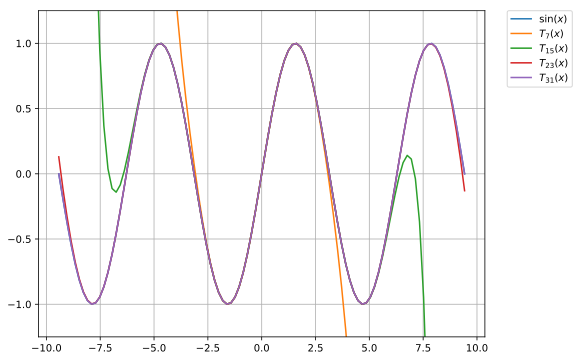

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.grid(True)
ax.set_ylim((-1.25, 1.25))

ax.plot(x, np.sin(x), label='$\sin{(x)}$')

for t in range(4, 20, 4):
    ax.plot(x, sin1(x, terms=t), 
            label='$T_{{{degree}}}(x)$'.format(degree=2*t-1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

The Taylor polynomial of 23 degrees appears to be making a decent approximation. Where we fall short with our implementation is that it is difficult to know what the approximation error is, let alone know upfront how many terms are actually required to obtain a good approximation.

What we really want is to continue adding terms to our approximation until the absolute value of the next term falls below some tolerable error threshold, since the error in the approximation will be no greater than the value of that term.

For example, if we use 5 terms to approximate $\sin{x}$:

$$
\sin{x} \approx x - \frac{x^3}{3!} + \frac{x^5}{5!} - \frac{x^7}{7!} + \frac{x^9}{9!}
$$

The error in this approximation is no greater than $\frac{{\mid x \mid}^{11}}{11!}$. In fact, for $x \in (-1, 1)$, the error is no greater than $2.6 \times 10^{-8}$:

In [15]:
fac = lambda n: next(islice(factorial(), n, n+1))

In [16]:
np.max(np.abs(np.linspace(-1, 1, 100))**11/fac(11))

2.505210838544172e-08

We can use the higher-order function `takewhile` to continuously obtain more terms to use in our approximation until the value of the term falls below some threshold. Here we take terms from the generator until it falls below $1 \times 10^{-20}$:

In [17]:
list(takewhile(lambda t: np.abs(t) > 1e-20, sin_terms(np.pi)))

[3.141592653589793,
 -5.167712780049969,
 2.550164039877345,
 -0.599264529320792,
 0.08214588661112822,
 -0.00737043094571435,
 0.00046630280576761245,
 -2.191535344783021e-05,
 7.95205400147551e-07,
 -2.2948428997269866e-08,
 5.392664662608127e-10,
 -1.051847171693206e-11,
 1.73021924583611e-13,
 -2.4325611799933874e-15,
 2.956701542854909e-17,
 -3.1377929634482263e-19]

Now we can define a sine function with an option to specify the maximum error that we can tolerate:

In [18]:
sin2 = lambda x, max_tol=1e-20: \
    sum(takewhile(lambda t: np.abs(t) > max_tol, sin_terms(x)))

In [19]:
sin2(.5*np.pi, max_tol=1e-15)

1.0

Again, we vectorize it to accept array inputs:

In [20]:
sin2 = np.vectorize(sin2, excluded=['max_tol'])

As a sanity check, we can ensure that given an array of $x$ values around a neighborhood of 0 as input, our implementation produces outputs that are element-wise equal to that of the NumPy implementation, within a certain tolerance.

In [21]:
x = np.linspace(-5*np.pi, 5*np.pi, 100)

In [22]:
np.allclose(np.sin(x), sin2(x))

True

When we plot the error, it is of no surprise that it increases exponentially as we get further away from 0.

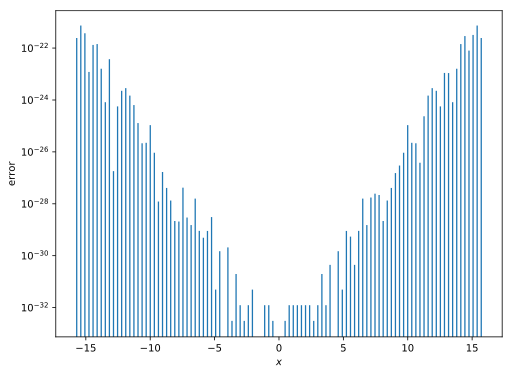

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x, (np.sin(x)-sin2(x))**2, width=.1, log=True)

ax.set_xlabel('$x$')
ax.set_ylabel('error')

plt.show()

To wrap this up, we provide a recursive implementation of our generator function:

In [24]:
def sin_terms(x, curr=None, n=2):

    if curr is None:
        curr = x

    yield curr
    yield from sin_terms(x, -curr*x**2/(n*(n+1)), n+2)

This is still considered a bottom-up approach, as we are still computing the current terms using the results of the previous terms, and no memoization is necessary. It is interesting to see recursion used in a generator function, and the use of the new `yield from` expression, [introduced in Python 3.3](https://docs.python.org/3/whatsnew/3.3.html#pep-380), which delegates part of its `yield` operations to another generator.

Now, it is trivial to adapt this implementation to $\cos{x}$. In fact, the body of the for-loop remains the same, the only change required is in the initial values of `curr` and `n`.

In [25]:
def cos_terms(x):

    curr = 1

    for n in count(1, 2):
        yield curr
        curr *= -x**2
        curr /= n*(n+1)

In [26]:
def cos_terms(x, curr=None, n=1):

    if curr is None:
        curr = 1

    yield curr
    yield from cos_terms(x, -curr*x**2/(n*(n+1)), n+2)

It would be useful and instructive to implement other common functions with recursion and the higher-order functions used in this notebook. It might even be possible to generalize further and implement a higher-order function which takes the initial values and parameters of the sequence as input, and returns a generator function as output. But we'll save that for another time.